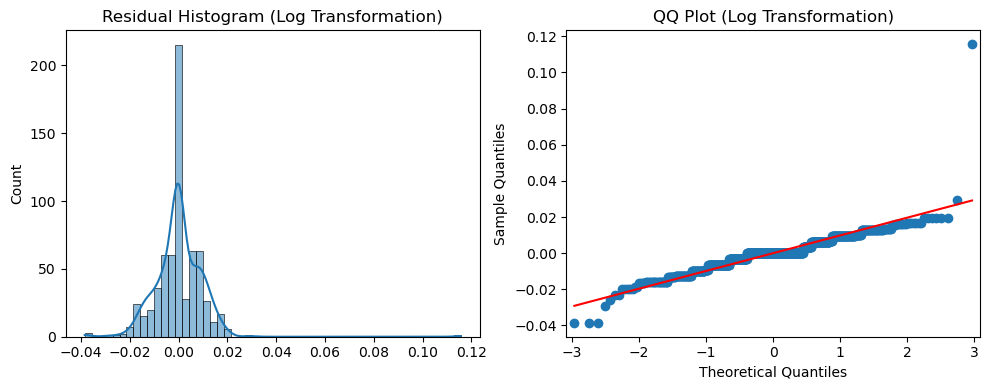

Log Transformation - Shapiro-Wilk p = 0.0000


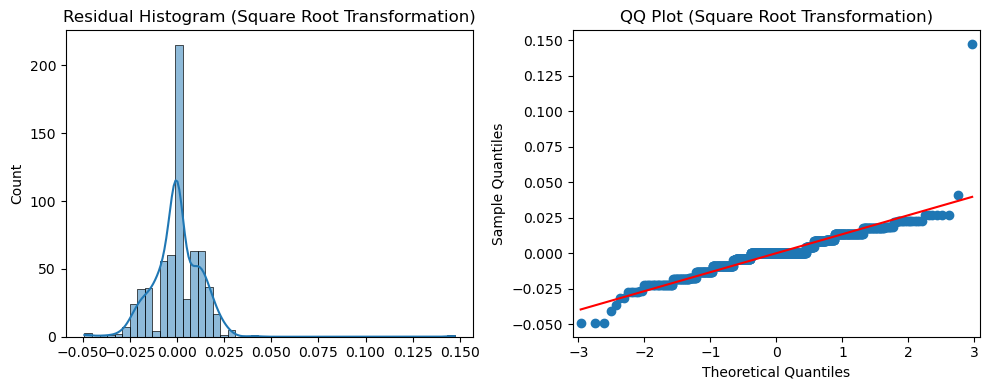

Square Root Transformation - Shapiro-Wilk p = 0.0000


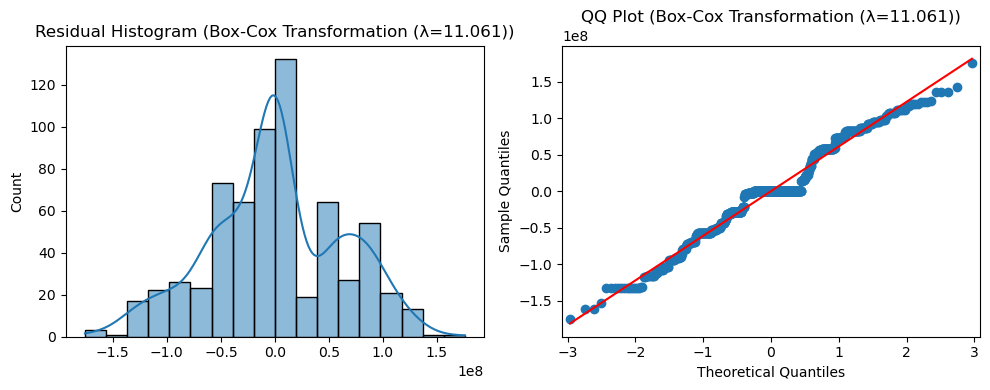

Box-Cox Transformation (λ=11.061) - Shapiro-Wilk p = 0.0000


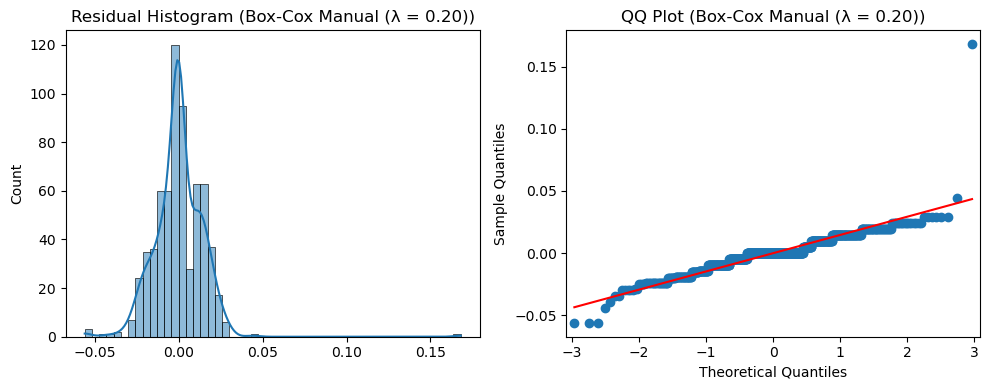

Box-Cox Manual (λ = 0.20) - Shapiro-Wilk p = 0.0000


C:\Users\Kenneth\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



=== Depth Effect Across Time ===


C:\Users\Kenneth\AppData\Local\Temp\ipykernel_27296\2169229387.py:210: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_significant, subset=["Welch p", "MWU p"])


,Day,Treatment,Compare,Group 1 Mean,Lower 1,Upper 1,Group 2 Mean,Lower 2,Upper 2,Welch p,Reject Welch,MWU p,Reject MWU
0,Day 1,Control,Depth 0 vs 1,7.88,7.79,7.96,7.93,7.88,7.97,0.4012,False❌,0.4357,False❌
1,Day 1,Control,Depth 0 vs 2,7.88,7.79,7.96,7.90,7.83,7.97,0.7052,False❌,0.7600,False❌
2,Day 1,Control,Depth 0 vs 3,7.88,7.79,7.96,7.93,7.84,8.01,0.4881,False❌,0.5412,False❌
3,Day 1,Control,Depth 0 vs 4,7.88,7.79,7.96,7.90,7.83,7.97,0.7052,False❌,0.7600,False❌
4,Day 1,Control,Depth 0 vs 5,7.88,7.79,7.96,7.88,7.79,7.96,1.0000,False❌,1.0000,False❌
5,Day 1,Control,Depth 0 vs 6,7.88,7.79,7.96,7.90,7.83,7.97,0.7052,False❌,0.7600,False❌
6,Day 1,Control,Depth 0 vs 7,7.88,7.79,7.96,7.90,7.80,8.00,0.7506,False❌,0.8744,False❌
7,Day 1,Control,Depth 0 vs 8,7.88,7.79,7.96,7.90,7.80,8.00,0.7506,False❌,0.8744,False❌
8,Day 1,Control,Depth 0 vs 9,7.88,7.79,7.96,7.93,7.88,7.97,0.4012,False❌,0.4357,False❌
9,Day 1,Control,Depth 0 vs 10,7.88,7.79,7.96,7.92,7.84,8.01,0.4881,False❌,0.5412,False❌



=== Treatment Effect at Each Depth ===


C:\Users\Kenneth\AppData\Local\Temp\ipykernel_27296\2169229387.py:210: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_significant, subset=["Welch p", "MWU p"])


,Day,Depth,Compare,Group 1 Mean,Lower 1,Upper 1,Group 2 Mean,Lower 2,Upper 2,Welch p,Reject Welch,MWU p,Reject MWU
0,Day 1,0,Control vs Root Mulched,7.88,7.79,7.96,7.92,7.84,8.01,0.4881,False❌,0.5412,False❌
1,Day 1,0,Control vs Root Mixed,7.88,7.79,7.96,7.85,7.80,7.90,0.6737,False❌,0.8744,False❌
2,Day 1,0,Control vs Leaf Mulched,7.88,7.79,7.96,7.95,7.90,8.00,0.2382,False❌,0.2849,False❌
3,Day 1,0,Control vs Leaf Mixed,7.88,7.79,7.96,7.88,7.79,7.96,1.0000,False❌,1.0000,False❌
4,Day 1,0,Root Mulched vs Root Mixed,7.92,7.84,8.01,7.85,7.80,7.90,0.2382,False❌,0.2849,False❌
5,Day 1,0,Root Mulched vs Leaf Mulched,7.92,7.84,8.01,7.95,7.90,8.00,0.6737,False❌,0.8744,False❌
6,Day 1,0,Root Mulched vs Leaf Mixed,7.92,7.84,8.01,7.88,7.79,7.96,0.4881,False❌,0.5412,False❌
7,Day 1,0,Root Mixed vs Leaf Mulched,7.85,7.80,7.90,7.95,7.90,8.00,0.0498,Tue✔️,0.0864,False❌
8,Day 1,0,Root Mixed vs Leaf Mixed,7.85,7.80,7.90,7.88,7.79,7.96,0.6737,False❌,0.8744,False❌
9,Day 1,0,Leaf Mulched vs Leaf Mixed,7.95,7.90,8.00,7.88,7.79,7.96,0.2382,False❌,0.2849,False❌



=== Time Effect Within Treatment by Depth ===


C:\Users\Kenneth\AppData\Local\Temp\ipykernel_27296\2169229387.py:210: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_significant, subset=["Welch p", "MWU p"])


,Treatment,Depth,Compare,Group 1 Mean,Lower 1,Upper 1,Group 2 Mean,Lower 2,Upper 2,Welch p,Reject Welch,MWU p,Reject MWU
0,Control,0,Day 1 vs Day 16,7.88,7.79,7.96,7.70,7.63,7.77,0.0328,Tue✔️,0.0530,False❌
1,Control,0,Day 1 vs Day 64,7.88,7.79,7.96,7.58,7.45,7.70,0.0193,Tue✔️,0.0485,True✔️
2,Control,0,Day 16 vs Day 64,7.70,7.63,7.77,7.58,7.45,7.70,0.2076,False❌,0.2308,False❌
3,Control,1,Day 1 vs Day 16,7.93,7.88,7.97,7.65,7.60,7.70,0.0004,Tue✔️,0.0247,True✔️
4,Control,1,Day 1 vs Day 64,7.93,7.88,7.97,7.68,7.57,7.78,0.0217,Tue✔️,0.0256,True✔️
5,Control,1,Day 16 vs Day 64,7.65,7.60,7.70,7.68,7.57,7.78,0.7354,False❌,0.6423,False❌
6,Control,2,Day 1 vs Day 16,7.90,7.83,7.97,7.62,7.54,7.71,0.0050,Tue✔️,0.0284,True✔️
7,Control,2,Day 1 vs Day 64,7.90,7.83,7.97,7.68,7.57,7.78,0.0290,Tue✔️,0.0396,True✔️
8,Control,2,Day 16 vs Day 64,7.62,7.54,7.71,7.68,7.57,7.78,0.5520,False❌,0.5357,False❌
9,Control,3,Day 1 vs Day 16,7.93,7.84,8.01,7.60,7.53,7.67,0.0022,Tue✔️,0.0284,True✔️


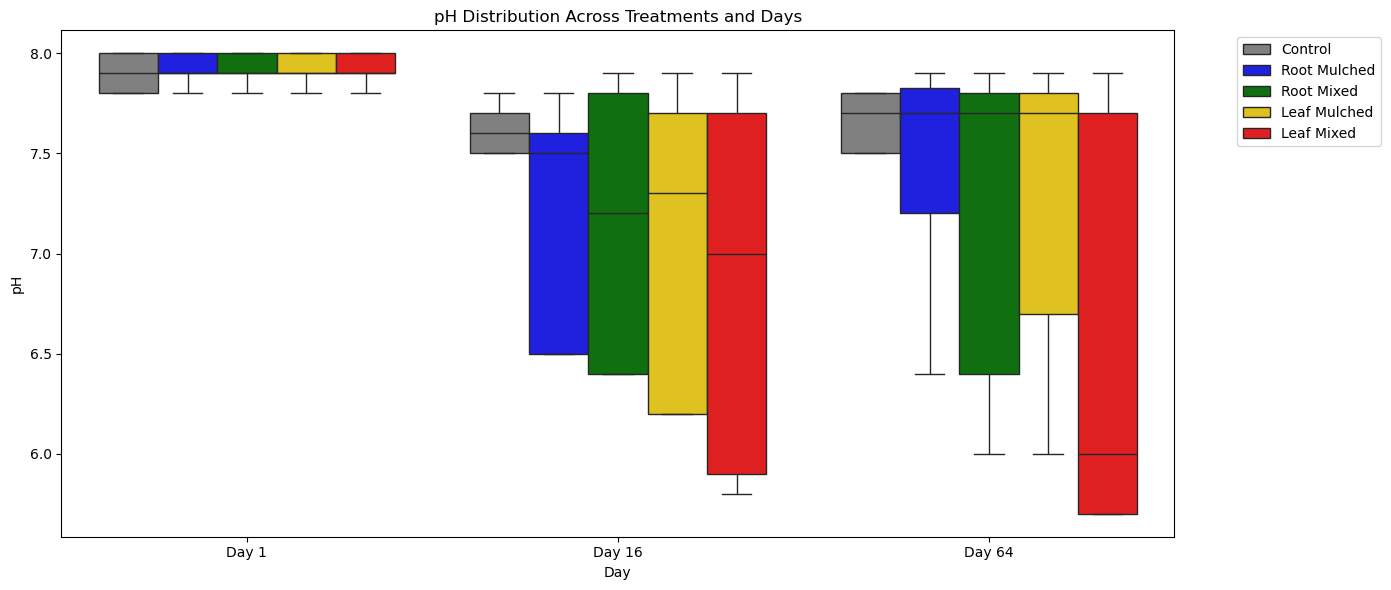

In [33]:
# ======================= Imports =======================
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import numpy as np

# ======================= Significance Level=======================
ALPHA = 0.05

# ======================= Data Setup =======================
data = {'Depth': [], 'pH': [], 'Treatment': [], 'Day': []}
depths = list(range(11))  # Depths 0 through 10

def add_treatment_data(treatment, day, depths, replicates):
    for depth_index, values in enumerate(replicates):
        for val in values:
            data['Depth'].append(depths[depth_index])
            data['pH'].append(val)
            data['Treatment'].append(treatment)
            data['Day'].append(day)


# Data for each treatment across 3 days
treatments = [
    ('Control', control_day1, control_day16, control_day64),
    ('Root Mulched', root_mulched_day1, root_mulched_day16, root_mulched_day64),
    ('Root Mixed', root_mixed_day1, root_mixed_day16, root_mixed_day64),
    ('Leaf Mulched', leaf_mulched_day1, leaf_mulched_day16, leaf_mulched_day64),
    ('Leaf Mixed', leaf_mixed_day1, leaf_mixed_day16, leaf_mixed_day64)
]

for treatment, d1, d16, d64 in treatments:
    for day, dataset in zip(['Day 1', 'Day 16', 'Day 64'], [d1, d16, d64]):
        add_treatment_data(treatment, day, depths, dataset)
df = pd.DataFrame(data)
df['Depth'] = pd.Categorical(df['Depth'], categories=depths, ordered=True)
df_filtered = df.copy()  # Use filtered copy for modeling
# ======================= Model Diagnostic Function =======================
def check_model(model, title):
    resid = model.resid
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(resid, kde=True, ax=axes[0])
    axes[0].set_title(f'Residual Histogram ({title})')

    sm.qqplot(resid, line='s', ax=axes[1])
    axes[1].set_title(f'QQ Plot ({title})')
    plt.tight_layout()
    plt.show()

    # 🔴 Shapiro-Wilk test for normality
    stat, p = stats.shapiro(resid)
    print(f"{title} - Shapiro-Wilk p = {p:.4f}")
    return p
# ======================= Try Transformations =======================

# 🔴 Log Transformation
df_log = df_filtered.copy()
df_log['log_pH'] = np.log(df_log['pH'])
model_log = ols('log_pH ~ C(Treatment)*C(Depth)*C(Day)', data=df_log).fit()
check_model(model_log, 'Log Transformation')

# 🔴 Square Root Transformation
df_sqrt = df_filtered.copy()
df_sqrt['sqrt_pH'] = np.sqrt(df_sqrt['pH'])
model_sqrt = ols('sqrt_pH ~ C(Treatment)*C(Depth)*C(Day)', data=df_sqrt).fit()
check_model(model_sqrt, 'Square Root Transformation')

# 🔴 Box-Cox Transformation (automatic λ)
boxcox_values, fitted_lambda = stats.boxcox(df_filtered['pH'])
df_boxcox = df_filtered.copy()
df_boxcox['pH_boxcox'] = boxcox_values
model_boxcox = ols('pH_boxcox ~ C(Treatment)*C(Depth)*C(Day)', data=df_boxcox).fit()
check_model(model_boxcox, f'Box-Cox Transformation (λ={fitted_lambda:.3f})')


# Try λ = 0.2 (manual Box-Cox)
lambda_reasonable = 0.2
pH_positive = df_filtered['pH'][df_filtered['pH'] > 0]  # Ensure values are strictly positive
pH_transformed = stats.boxcox(pH_positive, lmbda=lambda_reasonable)

df_filtered.loc[pH_positive.index, 'pH_boxcox_manual'] = pH_transformed

# Fit model
model_manual = ols('pH_boxcox_manual ~ C(Treatment)*C(Depth)*C(Day)', data=df_filtered).fit()
check_model(model_manual, f'Box-Cox Manual (λ = {lambda_reasonable:.2f})')



# --- Statistical Helpers ---
def run_tests(group1, group2):
    t_stat, p_t = ttest_ind(group1, group2, equal_var=False)
    u_stat, p_u = mannwhitneyu(group1, group2, alternative='two-sided')
    return round(p_t, 4), round(p_u, 4)

def highlight_significant(val, alpha=ALPHA):
    return 'color: red' if isinstance(val, float) and val < alpha else ''

def compute_summary_stats(arr):
    arr = np.array(arr)
    mean = np.mean(arr)
    std = np.std(arr)
    return round(mean, 2), round(mean - std, 2), round(mean + std, 2)

def reject_null(p_val):
    return p_val < ALPHA

# --- Constants ---
DEPTHS = list(range(11))
DAYS = ["Day 1", "Day 16", "Day 64"]
TREATMENT_LABELS = ["Control", "Root Mulched", "Root Mixed", "Leaf Mulched", "Leaf Mixed"]



# --- Data organization ---
TREATMENTS = {
    "Control":    [control_day1, control_day16, control_day64],
    "Root Mulched": [root_mulched_day1, root_mulched_day16, root_mulched_day64],
    "Root Mixed":   [root_mixed_day1, root_mixed_day16, root_mixed_day64],
    "Leaf Mulched": [leaf_mulched_day1, leaf_mulched_day16, leaf_mulched_day64],
    "Leaf Mixed":   [leaf_mixed_day1, leaf_mixed_day16, leaf_mixed_day64]
}

# --- Compare over time within treatment at each depth ---
def compare_over_time():
    results = []
    for treatment, days_data in TREATMENTS.items():
        for depth in DEPTHS:
            d1, d16, d64 = days_data[0][depth], days_data[1][depth], days_data[2][depth]
            for (label1, label2, data1, data2) in [
                ("Day 1", "Day 16", d1, d16),
                ("Day 1", "Day 64", d1, d64),
                ("Day 16", "Day 64", d16, d64),
            ]:
                p_t, p_u = run_tests(data1, data2)
                m1, l1, u1 = compute_summary_stats(data1)
                m2, l2, u2 = compute_summary_stats(data2)
                results.append({
                    "Treatment": treatment,
                    "Depth": depth,
                    "Compare": f"{label1} vs {label2}",
                    "Group 1 Mean": m1, "Lower 1": l1, "Upper 1": u1,
                    "Group 2 Mean": m2, "Lower 2": l2, "Upper 2": u2,
                    "Welch p": p_t,
                    "Reject Welch": reject_null(p_t),
                    "MWU p": p_u,
                    "Reject MWU": reject_null(p_u)
                })
    return pd.DataFrame(results)

# --- Compare treatments by depth per day ---
def compare_treatments_by_depth():
    results = []
    for day_idx, day_label in enumerate(DAYS):
        for depth in DEPTHS:
            for t1, t2 in combinations(TREATMENTS.keys(), 2):
                group1 = TREATMENTS[t1][day_idx][depth]
                group2 = TREATMENTS[t2][day_idx][depth]
                p_t, p_u = run_tests(group1, group2)
                m1, l1, u1 = compute_summary_stats(group1)
                m2, l2, u2 = compute_summary_stats(group2)
                results.append({
                    "Day": day_label,
                    "Depth": depth,
                    "Compare": f"{t1} vs {t2}",
                    "Group 1 Mean": m1, "Lower 1": l1, "Upper 1": u1,
                    "Group 2 Mean": m2, "Lower 2": l2, "Upper 2": u2,
                    "Welch p": p_t,
                    "Reject Welch": reject_null(p_t),
                    "MWU p": p_u,
                    "Reject MWU": reject_null(p_u)
                })
    return pd.DataFrame(results)

# --- Compare depths within treatment per day ---
def compare_depths_within_treatment():
    results = []
    for day_idx, day_label in enumerate(DAYS):
        for treatment, day_data in TREATMENTS.items():
            depths_data = day_data[day_idx]
            for d1, d2 in combinations(DEPTHS, 2):
                p_t, p_u = run_tests(depths_data[d1], depths_data[d2])
                m1, l1, u1 = compute_summary_stats(depths_data[d1])
                m2, l2, u2 = compute_summary_stats(depths_data[d2])
                results.append({
                    "Day": day_label,
                    "Treatment": treatment,
                    "Compare": f"Depth {d1} vs {d2}",
                    "Group 1 Mean": m1, "Lower 1": l1, "Upper 1": u1,
                    "Group 2 Mean": m2, "Lower 2": l2, "Upper 2": u2,
                    "Welch p": p_t,
                    "Reject Welch": reject_null(p_t),
                    "MWU p": p_u,
                    "Reject MWU": reject_null(p_u)
                })
    return pd.DataFrame(results)

# --- Display helpers ---
def display_styled(df, title):
    print(f"\n=== {title} ===")
    display(
        df.style
        .applymap(highlight_significant, subset=["Welch p", "MWU p"])
        .format({
            "Group 1 Mean": "{:.2f}", "Lower 1": "{:.2f}", "Upper 1": "{:.2f}",
            "Group 2 Mean": "{:.2f}", "Lower 2": "{:.2f}", "Upper 2": "{:.2f}",
            "Welch p": "{:.4f}", "MWU p": "{:.4f}",
            "Reject Welch": lambda x: "Tue✔️" if x else "False❌",
            "Reject MWU": lambda x: "True✔️" if x else "False❌"
        })
    )

# --- Run analyses ---
depth_time_df = compare_depths_within_treatment()
depth_treatment_df = compare_treatments_by_depth()
time_df = compare_over_time()

# --- Display styled results ---
display_styled(depth_time_df, "Depth Effect Across Time")
display_styled(depth_treatment_df, "Treatment Effect at Each Depth")
display_styled(time_df, "Time Effect Within Treatment by Depth")


# --- Visualization ---
plt.figure(figsize=(14, 6))

# Define custom palette
custom_palette = {
    "Control": "gray",
    "Root Mulched": "blue",
    "Root Mixed": "green",
    "Leaf Mulched": "gold",
    "Leaf Mixed": "red"
}

# Apply palette in boxplot
sns.boxplot(data=df_filtered, x="Day", y="pH", hue="Treatment", palette=custom_palette)

plt.title("pH Distribution Across Treatments and Days")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# ======================= Imports =======================
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# ======================= Data Setup =======================
data = {'Depth': [], 'pH': [], 'Treatment': [], 'Day': []}
depths = list(range(11))  # Depths 0 through 10

def add_treatment_data(treatment, day, depths, replicates):
    for depth_index, values in enumerate(replicates):
        for val in values:
            data['Depth'].append(depths[depth_index])
            data['pH'].append(val)
            data['Treatment'].append(treatment)
            data['Day'].append(day)
# Data for each treatment across 3 days
treatments = [
    ('Control', control_day1, control_day16, control_day64),
    ('Root Mulched', root_mulched_day1, root_mulched_day16, root_mulched_day64),
    ('Root Mixed', root_mixed_day1, root_mixed_day16, root_mixed_day64),
    ('Leaf Mulched', leaf_mulched_day1, leaf_mulched_day16, leaf_mulched_day64),
    ('Leaf Mixed', leaf_mixed_day1, leaf_mixed_day16, leaf_mixed_day64)
]

for treatment, d1, d16, d64 in treatments:
    for day, dataset in zip(['Day 1', 'Day 16', 'Day 64'], [d1, d16, d64]):
        add_treatment_data(treatment, day, depths, dataset)
df = pd.DataFrame(data)
df['Depth'] = pd.Categorical(df['Depth'], categories=depths, ordered=True)
df_filtered = df.copy()  # Use filtered copy for modeling
# ======================= Model Diagnostic Function =======================
def check_model(model, title):
    resid = model.resid
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(resid, kde=True, ax=axes[0])
    axes[0].set_title(f'Residual Histogram ({title})')

    sm.qqplot(resid, line='s', ax=axes[1])
    axes[1].set_title(f'QQ Plot ({title})')
    plt.tight_layout()
    plt.show()

    # 🔴 Shapiro-Wilk test for normality
    stat, p = stats.shapiro(resid)
    print(f"{title} - Shapiro-Wilk p = {p:.4f}")
    return p
# ======================= Try Transformations =======================

# 🔴 Log Transformation
df_log = df_filtered.copy()
df_log['log_pH'] = np.log(df_log['pH'])
model_log = ols('log_pH ~ C(Treatment)*C(Depth)*C(Day)', data=df_log).fit()
check_model(model_log, 'Log Transformation')

# 🔴 Square Root Transformation
df_sqrt = df_filtered.copy()
df_sqrt['sqrt_pH'] = np.sqrt(df_sqrt['pH'])
model_sqrt = ols('sqrt_pH ~ C(Treatment)*C(Depth)*C(Day)', data=df_sqrt).fit()
check_model(model_sqrt, 'Square Root Transformation')

# 🔴 Box-Cox Transformation (automatic λ)
boxcox_values, fitted_lambda = stats.boxcox(df_filtered['pH'])
df_boxcox = df_filtered.copy()
df_boxcox['pH_boxcox'] = boxcox_values
model_boxcox = ols('pH_boxcox ~ C(Treatment)*C(Depth)*C(Day)', data=df_boxcox).fit()
check_model(model_boxcox, f'Box-Cox Transformation (λ={fitted_lambda:.3f})')

# Try λ = 0 (log) or λ = 0.5 (sqrt)
lambda_reasonable = 0.2 # square root
pH_transformed = stats.boxcox(pH_positive, lmbda=lambda_reasonable)
df_filtered['pH_boxcox_manual'] = pH_transformed

model_manual = ols('pH_boxcox_manual ~ C(Treatment)*C(Depth)*C(Day)', data=df_filtered).fit()
check_model(model_manual, f'Box-Cox Manual (λ = {lambda_reasonable:.2f})')


import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
from itertools import combinations

# Constants
DEPTHS = list(range(11))
DAYS = ["Day 1", "Day 16", "Day 64"]
ALPHA = 0.05

# Organize pH data by treatment and day
TREATMENTS = {
    "Control": [control_day1, control_day16, control_day64],
    "Root Mulched": [root_mulched_day1, root_mulched_day16, root_mulched_day64],
    "Root Mixed": [root_mixed_day1, root_mixed_day16, root_mixed_day64],
    "Leaf Mulched": [leaf_mulched_day1, leaf_mulched_day16, leaf_mulched_day64],
    "Leaf Mixed": [leaf_mixed_day1, leaf_mixed_day16, leaf_mixed_day64],
}

# Helper for significance testing
def run_tests(group1, group2):
    t_stat, p_t = ttest_ind(group1, group2, equal_var=False)
    u_stat, p_u = mannwhitneyu(group1, group2, alternative='two-sided')
    return round(p_t, 4), round(p_u, 4)

# Highlight significance in styled DataFrames
def highlight_significant(val, alpha=ALPHA):
    return 'color: red' if isinstance(val, float) and val < alpha else ''

# Compare days within a treatment at each depth
def compare_over_time():
    results = []
    for treatment, days_data in TREATMENTS.items():
        for depth in DEPTHS:
            d1, d16, d64 = days_data[0][depth], days_data[1][depth], days_data[2][depth]
            for (label1, label2, data1, data2) in [
                ("Day 1", "Day 16", d1, d16),
                ("Day 1", "Day 64", d1, d64),
                ("Day 16", "Day 64", d16, d64),
            ]:
                p_t, p_u = run_tests(data1, data2)
                results.append({
                    "Treatment": treatment,
                    "Depth": depth,
                    "Compare": f"{label1} vs {label2}",
                    "Welch p": p_t,
                    "MWU p": p_u
                })
    return pd.DataFrame(results)

# Compare treatments at each depth for each day
def compare_treatments_by_depth():
    results = []
    for day_idx, day_label in enumerate(DAYS):
        for depth in DEPTHS:
            for t1, t2 in combinations(TREATMENTS.keys(), 2):
                group1 = TREATMENTS[t1][day_idx][depth]
                group2 = TREATMENTS[t2][day_idx][depth]
                p_t, p_u = run_tests(group1, group2)
                results.append({
                    "Day": day_label,
                    "Depth": depth,
                    "Compare": f"{t1} vs {t2}",
                    "Welch p": p_t,
                    "MWU p": p_u
                })
    return pd.DataFrame(results)

# Compare depths within each treatment per day
def compare_depths_within_treatment():
    results = []
    for day_idx, day_label in enumerate(DAYS):
        for treatment, day_data in TREATMENTS.items():
            depths_data = day_data[day_idx]
            for d1, d2 in combinations(DEPTHS, 2):
                p_t, p_u = run_tests(depths_data[d1], depths_data[d2])
                results.append({
                    "Day": day_label,
                    "Treatment": treatment,
                    "Compare": f"Depth {d1} vs {d2}",
                    "Welch p": p_t,
                    "MWU p": p_u
                })
    return pd.DataFrame(results)

# Display styled result
def display_styled(df, title):
    print(f"\n=== {title} ===")
    display(df.style
            .applymap(highlight_significant, subset=["Welch p", "MWU p"])
            .format({"Welch p": "{:.4f}", "MWU p": "{:.4f}"}))

# Run all comparisons
depth_time_df = compare_depths_within_treatment()
depth_treatment_df = compare_treatments_by_depth()
time_df = compare_over_time()

# Show results
display_styled(depth_time_df, "Depth Effect Across Time")
display_styled(depth_treatment_df, "Treatment Effect at Each Depth")
display_styled(time_df, "Time Effect Within Treatment by Depth")

from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd

# Constants
depths = list(range(11))  # 0 to 10 cm
days = ["Day 1", "Day 16", "Day 64"]

# Treatment data per day
treatments_by_day = {
    "Day 1": {
        "Control": control_day1,
        "Root Mulched": root_mulched_day1,
        "Root Mixed": root_mixed_day1,
        "Leaf Mulched": leaf_mulched_day1,
        "Leaf Mixed": leaf_mixed_day1,
    },
    "Day 16": {
        "Control": control_day16,
        "Root Mulched": root_mulched_day16,
        "Root Mixed": root_mixed_day16,
        "Leaf Mulched": leaf_mulched_day16,
        "Leaf Mixed": leaf_mixed_day16,
    },
    "Day 64": {
        "Control": control_day64,
        "Root Mulched": root_mulched_day64,
        "Root Mixed": root_mixed_day64,
        "Leaf Mulched": leaf_mulched_day64,
        "Leaf Mixed": leaf_mixed_day64,
    },
}

# Store test results
depth_treatment_results = []

# Compare treatments at each depth, per day
for day_label, treatments in treatments_by_day.items():
    treatment_names = list(treatments.keys())
    for depth in depths:
        for t1, t2 in combinations(treatment_names, 2):
            group1 = treatments[t1][depth]
            group2 = treatments[t2][depth]

            # Welch's t-test and Mann-Whitney U test
            t_stat, p_ttest = ttest_ind(group1, group2, equal_var=False)
            u_stat, p_mwu = mannwhitneyu(group1, group2, alternative='two-sided')

            depth_treatment_results.append({
                "Day": day_label,
                "Depth": depth,
                "Compare": f"{t1} vs {t2}",
                "Welch p": round(p_ttest, 4),
                "MWU p": round(p_mwu, 4)
            })

# Convert to DataFrame
depth_treatment_df = pd.DataFrame(depth_treatment_results)

# Style helper
def highlight_significant(val, alpha=0.05):
    if isinstance(val, float) and val < alpha:
        return 'color: red'
    return ''

# Display styled table
print("=== Depth Effect Across Treatments ===")
display(
    depth_treatment_df.style
        .applymap(highlight_significant, subset=["Welch p", "MWU p"])
        .format({"Welch p": "{:.4f}", "MWU p": "{:.4f}"})
)

from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd

# Constants
depths = list(range(11))  # 0 to 10 cm
days = ["Day 1", "Day 16", "Day 64"]

# Organize treatment data by day
treatments_by_day = {
    "Day 1": {
        "Control": control_day1,
        "Root Mulched": root_mulched_day1,
        "Root Mixed": root_mixed_day1,
        "Leaf Mulched": leaf_mulched_day1,
        "Leaf Mixed": leaf_mixed_day1,
    },
    "Day 16": {
        "Control": control_day16,
        "Root Mulched": root_mulched_day16,
        "Root Mixed": root_mixed_day16,
        "Leaf Mulched": leaf_mulched_day16,
        "Leaf Mixed": leaf_mixed_day16,
    },
    "Day 64": {
        "Control": control_day64,
        "Root Mulched": root_mulched_day64,
        "Root Mixed": root_mixed_day64,
        "Leaf Mulched": leaf_mulched_day64,
        "Leaf Mixed": leaf_mixed_day64,
    },
}

# Store results
depth_time_results = []

# Compare depths over time within each treatment
for treatment in treatments_by_day["Day 1"].keys():  # All treatments assumed same across days
    for depth in depths:
        # Get same-depth data across days
        d1 = treatments_by_day["Day 1"][treatment][depth]
        d16 = treatments_by_day["Day 16"][treatment][depth]
        d64 = treatments_by_day["Day 64"][treatment][depth]

        for (label_a, label_b, arr_a, arr_b) in [
            ("Day 1", "Day 16", d1, d16),
            ("Day 1", "Day 64", d1, d64),
            ("Day 16", "Day 64", d16, d64)
        ]:
            # Welch's t-test and Mann-Whitney U test
            t_stat, p_ttest = ttest_ind(arr_a, arr_b, equal_var=False)
            u_stat, p_mwu = mannwhitneyu(arr_a, arr_b, alternative='two-sided')

            depth_time_results.append({
                "Treatment": treatment,
                "Depth": depth,
                "Compare": f"{label_a} vs {label_b}",
                "Welch p": round(p_ttest, 4),
                "MWU p": round(p_mwu, 4)
            })

# Create DataFrame
depth_time_df = pd.DataFrame(depth_time_results)

# Style helper
def highlight_significant(val, alpha=0.05):
    if isinstance(val, float) and val < alpha:
        return 'color: red'
    return ''

# Display styled table
print("=== Depth Effect Across Time ===")
display(
    depth_time_df.style
        .applymap(highlight_significant, subset=["Welch p", "MWU p"])
        .format({"Welch p": "{:.4f}", "MWU p": "{:.4f}"})
)


from itertools import combinations
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd

# Constants
depths = list(range(11))  # 0 to 10 cm
days = ["Day 1", "Day 16", "Day 64"]
treatment_labels = ["Control", "Root Mulched", "Root Mixed", "Leaf Mulched", "Leaf Mixed"]

# Organize all data by day
all_data_by_day = {
    "Day 1": {
        "Control": control_day1,
        "Root Mulched": root_mulched_day1,
        "Root Mixed": root_mixed_day1,
        "Leaf Mulched": leaf_mulched_day1,
        "Leaf Mixed": leaf_mulched_day1,
    },
    "Day 16": {
        "Control": control_day16,
        "Root Mulched": root_mulched_day16,
        "Root Mixed": root_mixed_day16,
        "Leaf Mulched": leaf_mulched_day16,
        "Leaf Mixed": leaf_mulched_day16,
    },
    "Day 64": {
        "Control": control_day64,
        "Root Mulched": root_mulched_day64,
        "Root Mixed": root_mixed_day64,
        "Leaf Mulched": leaf_mulched_day64,
        "Leaf Mixed": leaf_mixed_day64,
    },
}

# Store results
interaction_results = []

# Compare treatment combinations at each depth for each day
for day in days:
    treatments = all_data_by_day[day]
    
    for depth in depths:
        for (treat_a, treat_b) in combinations(treatments.keys(), 2):
            arr_a = treatments[treat_a][depth]
            arr_b = treatments[treat_b][depth]

            # Welch's t-test and Mann-Whitney U
            t_stat, p_ttest = ttest_ind(arr_a, arr_b, equal_var=False)
            u_stat, p_mwu = mannwhitneyu(arr_a, arr_b, alternative='two-sided')

            interaction_results.append({
                "Day": day,
                "Depth": depth,
                "Compare": f"{treat_a} vs {treat_b}",
                "Welch p": round(p_ttest, 4),
                "MWU p": round(p_mwu, 4)
            })

# Convert to DataFrame
interaction_df = pd.DataFrame(interaction_results)

# Styling
def highlight_significant(val, alpha=0.05):
    if isinstance(val, float) and val < alpha:
        return 'color: red'
    return ''

# Display
print("=== Depth × Treatment × Time Interaction ===")
display(
    interaction_df.style
        .applymap(highlight_significant, subset=["Welch p", "MWU p"])
        .format({"Welch p": "{:.4f}", "MWU p": "{:.4f}"})
)



# ---  Visualization ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_filtered, x="Day", y="pH", hue="Treatment")
plt.title("pH Distribution Across Treatments and Days")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
